In [71]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default_light")
import logging

from gpso.param_space import ParameterSpace
from anytree import RenderTree, PreOrderIter, PostOrderIter
from gpso.optimisation import GPSOptimiser
from gpso.gp_surrogate import PointLabels
from gpso.plotting import plot_parameter_marginal_distributions, plot_conditional_surrogate_distributions, plot_ternary_tree
from tools.utils import set_logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# DEFINE BASICS

def obj(point, offset=0., rotate=True):
    x, y = point
    if rotate:
        ct = np.cos(np.pi/4)
        st = np.sin(np.pi/4)
        xn = ct*x + st*y
        yn = ct*y - st*x
        x = xn
        y = yn
    return 3*(1-x)**2. * np.exp(-(x**2) - (y+1)**2) - 10*(x/5. - x**3 - y**5)*np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2 - y**2) - offset


x_bounds = [-3, 5]
y_bounds = [-3, 3]
N_POINTS = 120

Text(0.5, 1.0, 'Reference surface')

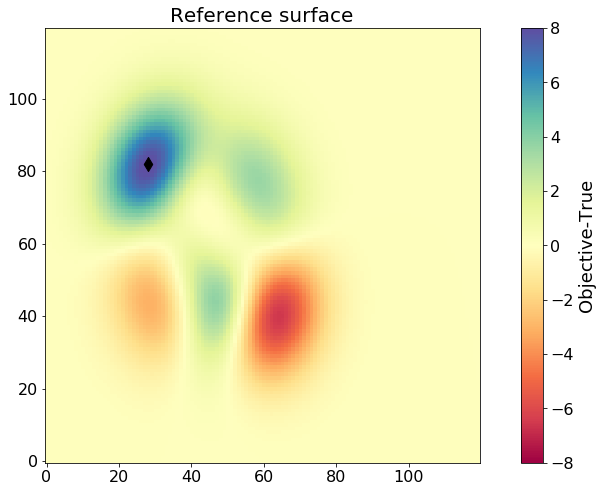

In [3]:
# true objective - reference surface
x = np.linspace(x_bounds[0], x_bounds[1], N_POINTS)
y = np.linspace(y_bounds[0], y_bounds[1], N_POINTS)
x, y = np.meshgrid(x, y)
o = obj([x, y], rotate=True)
plt.imshow(o, vmax=8., vmin=-8., cmap=plt.get_cmap("Spectral"), origin='lower')
cbar = plt.colorbar()
i, j = np.unravel_index(o.argmax(), o.shape)
plt.scatter(j, i , marker='d', color='black')
cbar.set_label("Objective-True")
plt.title("Reference surface")

In [4]:
space = ParameterSpace(parameter_names=["x", "y"], parameter_bounds=[x_bounds, y_bounds])
opt = GPSOptimiser(parameter_space=space, exploration_method="sample", exploration_depth=3, update_cycle=1, 
                   budget=50, stopping_condition="evaluations", gp_lik_sigma=1.0e-3, n_workers=4)

In [5]:
set_logger(log_level=logging.DEBUG)
best_point = opt.run(obj)

[2020-01-24 00:49:45] INFO: Starting 2-dimensional optimisation with budget of 50 objective function evaluations...
[2020-01-24 00:49:45] INFO: Sampling 2 vertices per dimension within L1 ball of 0.25 of the domain size radius in normalised coordinates using 4 workers...
[2020-01-24 00:49:46] DEBUG: Initialised with 5 points:
	[-1.  0.]: -0.027968249216549473
	[ 1.  -1.5]: -4.002896000164235
	[3. 0.]: -0.02983833021721474
	[1.  1.5]: 2.019346080880167
	[1. 0.]: 0.26236126926038383
[2020-01-24 00:49:46] INFO: Update step: retraining GP model and updating scores...


Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


[2020-01-24 00:49:46] WARNING: From /Users/nikola/.virtualenvs/sleepy3/lib/python3.7/site-packages/gpflow/utilities/bijectors.py:28: AffineScalar.__init__ (from tensorflow_probability.python.bijectors.affine_scalar) is deprecated and will be removed after 2020-01-01.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
[2020-01-24 00:49:48] INFO: Exploration step: sampling children in the ternary tree...
[2020-01-24 00:49:48] DEBUG: Exploring 0 level...
[2020-01-24 00:49:48] DEBUG: full_domain->l best score: 9.503745089042745
[2020-01-24 00:49:48] DEBUG: full_domain->c best score: 0.26236126926038383
[2020-01-24 00:49:48] DEBUG: full_domain->r best score: 10.330796172311127
[2020-01-24 00:49:48] INFO: Selecting step: evaluating best leaves...
[2020-01-24 00:49:48] DEBUG: Selecting within 0 level...
[2020-01-24 00:49:48] DEBUG: Selecting within 1 level...
[2020-01-24 00:49:48] WARNING: Duplicate found! Overwriting with ne

In [6]:
best_point

GPPoint(normed_coord=array([0.23388203, 0.68518519]), score_mu=8.106012429922291, score_sigma=0.0, score_ucb=0.0, label=<PointLabels.evaluated: 1>)

[2020-01-24 00:49:59] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1463438d0>
[2020-01-24 00:49:59] DEBUG: Using auto colorbar locator on colorbar
[2020-01-24 00:49:59] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1463438d0>
[2020-01-24 00:49:59] DEBUG: Setting pcolormesh


Text(0.5, 1.0, 'Reference surface')

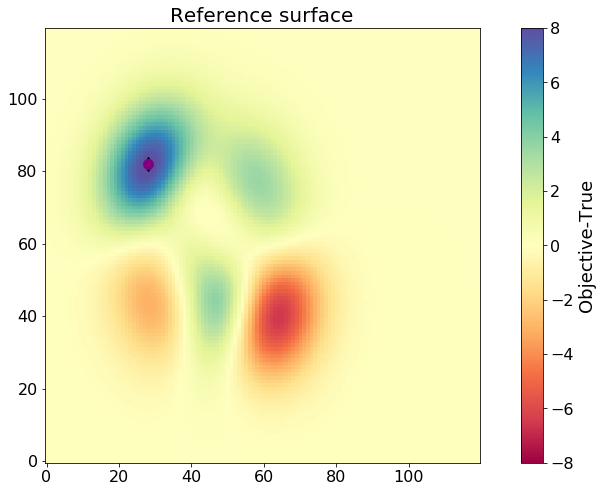

In [7]:
plt.imshow(o, vmax=8., vmin=-8., cmap=plt.get_cmap("Spectral"), origin='lower')
cbar = plt.colorbar()
i, j = np.unravel_index(o.argmax(), o.shape)
plt.scatter(j, i , marker='d', color='black')
ii, jj = best_point.normed_coord
plt.scatter(int(np.around(ii*N_POINTS)), int(np.around(jj*N_POINTS)), marker='o', color='purple')
cbar.set_label("Objective-True")
plt.title("Reference surface")

In [8]:
stk = np.hstack([x.reshape((-1, 1)), y.reshape((-1, 1))])
mean, var = opt.gp_surr.gpr_model.predict_y(opt.param_space.normalise_coords(stk))
mean = mean.numpy().reshape(x.shape)
var = var.numpy().reshape(x.shape)

[2020-01-24 00:50:00] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x146342590>
[2020-01-24 00:50:00] DEBUG: Using auto colorbar locator on colorbar
[2020-01-24 00:50:00] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x146342590>
[2020-01-24 00:50:00] DEBUG: Setting pcolormesh


Text(0.5, 1.0, 'Surrogate surface')

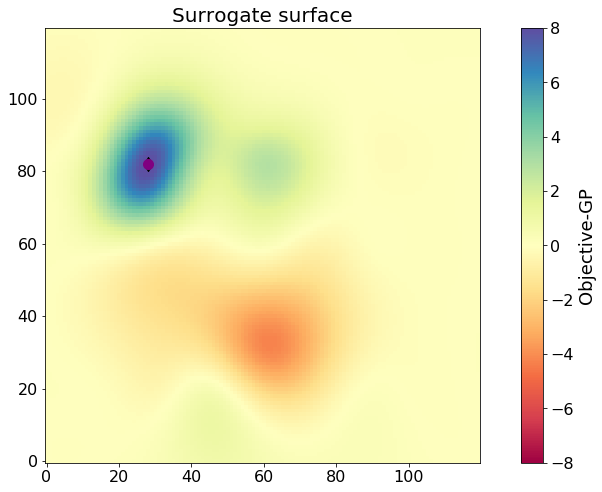

In [9]:
plt.imshow(mean, vmax=8., vmin=-8., cmap=plt.get_cmap("Spectral"), origin='lower')
cbar = plt.colorbar()
i, j = np.unravel_index(o.argmax(), o.shape)
plt.scatter(j, i , marker='d', color='black')
ii, jj = best_point.normed_coord
plt.scatter(int(np.around(ii*N_POINTS)), int(np.around(jj*N_POINTS)), marker='o', color='purple')
cbar.set_label("Objective-GP")
plt.title("Surrogate surface")

[2020-01-24 00:50:00] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x146068810>
[2020-01-24 00:50:00] DEBUG: Using auto colorbar locator on colorbar
[2020-01-24 00:50:00] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x146068810>
[2020-01-24 00:50:00] DEBUG: Setting pcolormesh
[2020-01-24 00:50:00] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x146a714d0>
[2020-01-24 00:50:00] DEBUG: Using auto colorbar locator on colorbar
[2020-01-24 00:50:00] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x146a714d0>
[2020-01-24 00:50:00] DEBUG: Setting pcolormesh
[2020-01-24 00:50:00] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x146af4310>
[2020-01-24 00:50:00] DEBUG: Using auto colorbar locator on colorbar
[2020-01-24 00:50:00] DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x146af4310>
[2020-01-24 00:50:00] DEBUG: Setting pcolormesh
[2020-01-24 00:50:01] DEBUG: lo

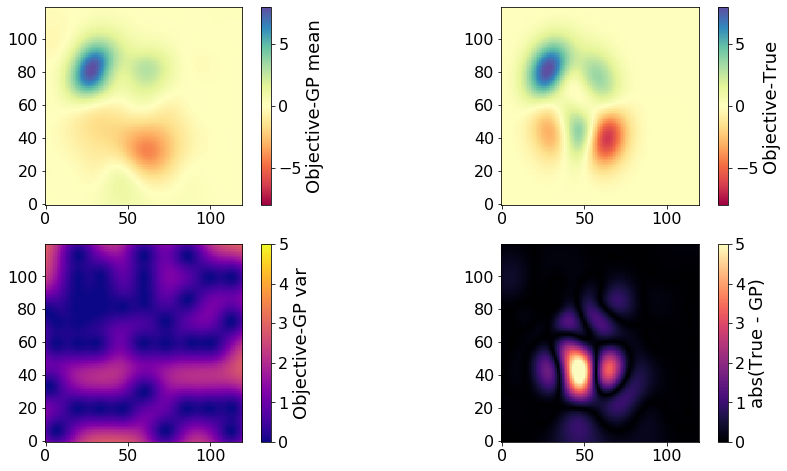

In [10]:
plt.subplot(2, 2, 1)
plt.imshow(mean, vmax=8., vmin=-8., cmap=plt.get_cmap("Spectral"), origin='lower')
cbar = plt.colorbar()
cbar.set_label("Objective-GP mean")
plt.subplot(2, 2, 3)
plt.imshow(var, vmax=5., vmin=0., cmap=plt.get_cmap("plasma"), origin='lower')
cbar = plt.colorbar()
cbar.set_label("Objective-GP var")

plt.subplot(2, 2, 2)
plt.imshow(o, vmax=8., vmin=-8., cmap=plt.get_cmap("Spectral"), origin='lower')
cbar = plt.colorbar()
cbar.set_label("Objective-True")
plt.subplot(2, 2, 4)
plt.imshow(np.abs(o - mean), vmax=5., vmin=0, cmap=plt.get_cmap("magma"), origin='lower')
cbar = plt.colorbar()
cbar.set_label("abs(True - GP)")

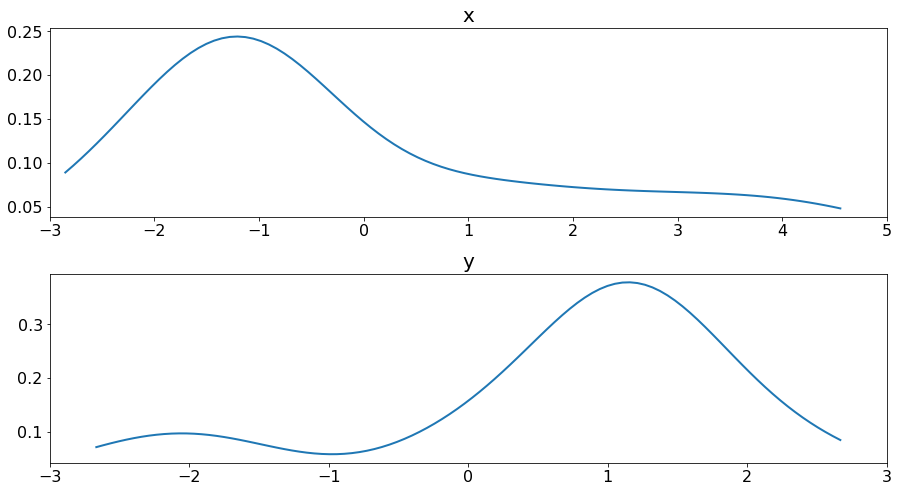

In [11]:
plot_parameter_marginal_distributions(opt, percentile=0., plot_type="kde")

/Users/nikola/.virtualenvs/sleepy3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nikola/.virtualenvs/sleepy3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nikola/.virtualenvs/sleepy3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/nikola/.virtualenvs/sleepy3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/nikola/.virtualenvs/sleepy3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


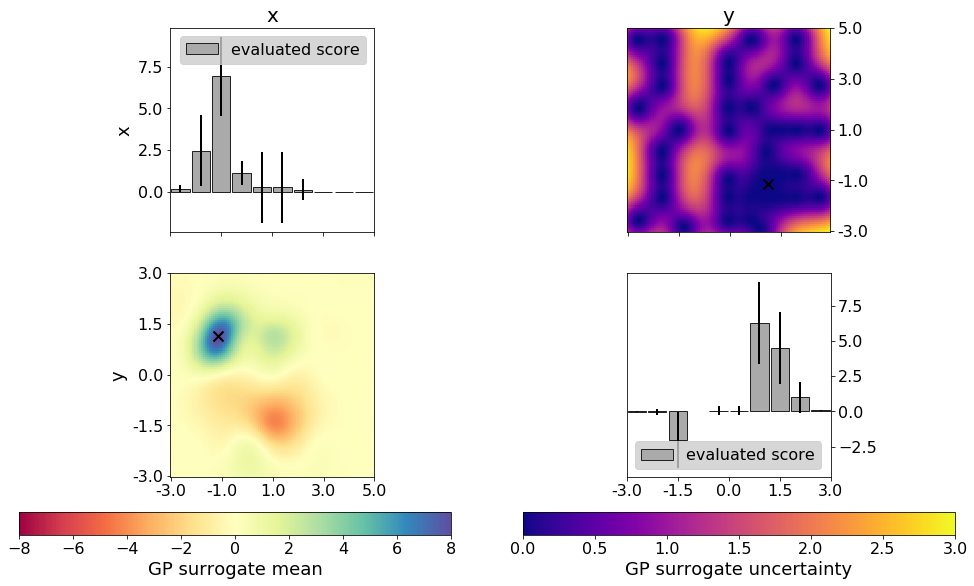

In [12]:
set_logger(log_level=logging.INFO)
plot_conditional_surrogate_distributions(opt, mean_limits=(-8, 8), var_limits=(0, 3))

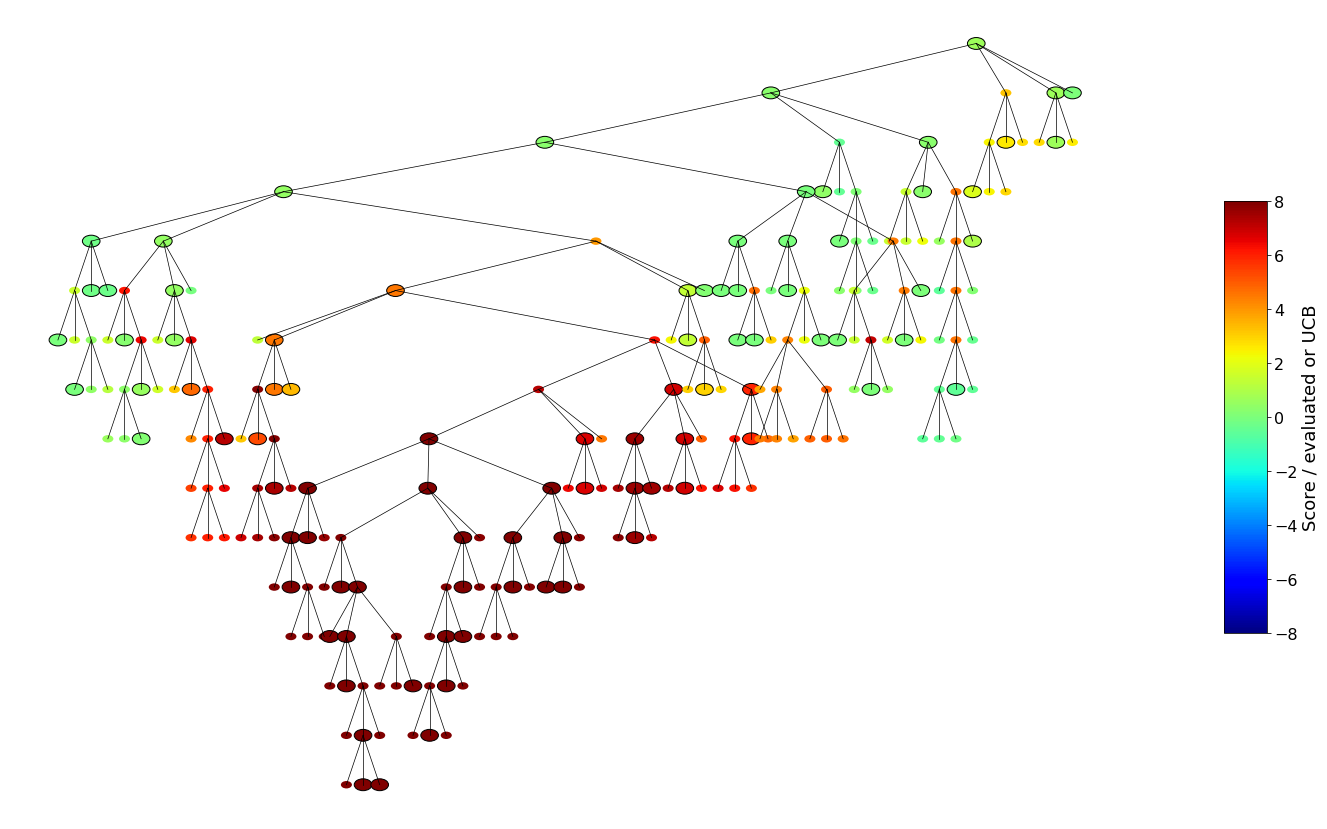

In [142]:
plot_ternary_tree(opt.param_space, cmap="jet", figsize=(20, 15), center_root_node=False, cmap_limits=[-8, 8])